In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import *

from math import sqrt, atan, log, exp, sin, cos, tan, trunc, isclose, tanh

import datetime
from datetime import timezone
from datetime import time
from datetime import timedelta

import calendar

import pytz
from functools import reduce

from tools import *
from model import *
from graph import *


# Pandas environment settings: 
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

# Project

In [2]:
project  = 'A'

# Read data
df = pd.read_csv("A_cleaned_data_identification.csv", index_col=0)

In [3]:
df.index[0]

'2022-11-01 00:00:00'

In [4]:
# UTC Time zone
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize('UTC')

In [5]:
df.index[0]

Timestamp('2022-11-01 00:00:00+0000', tz='UTC')

In [6]:
df.columns

Index(['t_set', 'f_occ', 't_i', 'V_g', 't_e', 'leave', 'leave_fwb',
       't_set_default', 'f_occ_pred', 't_e_air', 'hhv', 'gamma_s_deg',
       'h_s_deg', 'theta_z_deg', 'I_th', 'I_bh', 't_e_we'],
      dtype='object')

# Zone data

In [7]:
gamma_w_z_deg = - 62      # Azimuth of the normal to the facade
A_fl_z = 592.58 + 518.4  # floor heated area
rho_ground = 0.5         # Surrounding environment reflexion factor

In [8]:
df["t_set"].value_counts()

t_set
15.0    7986
20.0    5407
12.0    3342
17.5      10
Name: count, dtype: int64

In [9]:
df["t_set_occ"] = 20
t_set_occ = df["t_set_occ"].values

t_set_leave = 12

In [10]:
# Heating power
time_step_s      = (df.index[1] - df.index[0]).total_seconds()
df['Q_dot_g']    = df['V_g'] * df['hhv'] * 1000 * 3600 / time_step_s
df['Q_dot_g_m1'] = df['Q_dot_g'].shift(-1, fill_value=0) # only fills the NaN values created by the .shift operation 
df['Q_dot_g_p1'] = df['Q_dot_g'].shift(+1, fill_value=0) # only fills the NaN values created by the .shift operation 

# Estimate maxiumum heating power
Q_dot_n_z = df["Q_dot_g"].max() 

print('Max heating power of the zone :', int(Q_dot_n_z), ' (kW)')

Max heating power of the zone : 125467  (kW)


In [11]:
# UTC time zone
df['ts'] = (df.index.to_series().view('int64') - df.index.to_series().view('int64').iloc[0])/ 10**9

df['date_utc'] = df.index
df['hour_utc'] = df['date_utc'].dt.hour

# Convert index to Brussels timezone and store it in a new column (without affecting the timezone of the index)
brussels_tz = pytz.timezone('Europe/Brussels')

df['date']       = df.index.tz_convert(brussels_tz)
df['hour']       = df['date'].dt.hour
df['minute']     = df['date'].dt.minute
df['dayofmonth'] = df['date'].dt.day
df['month']      = df['date'].dt.month
df['year']       = df['date'].dt.year
df['dayname']    = df['date'].dt.day_name()
df['dayofweek']  = df['date'].dt.dayofweek
df['dayofyear']  = df['date'].dt.dayofyear

# Convert time to float (hours)
df["time_float"]     = df['date'].dt.hour + df['date'].dt.minute / 60.0
df['hourofyear_int'] = df['date'].dt.dayofyear * 24 + df['date'].dt.hour

# Plot data

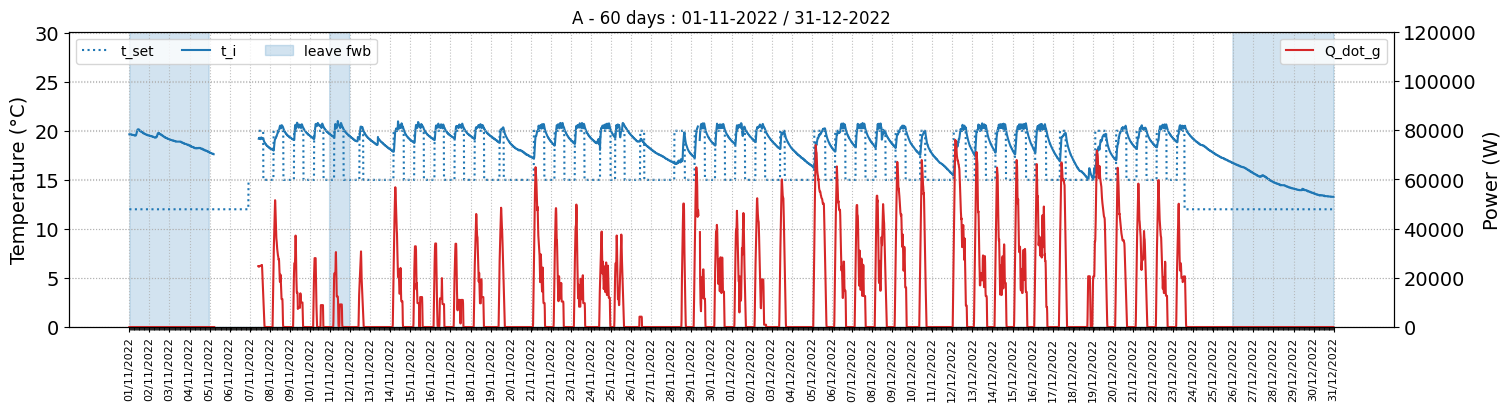

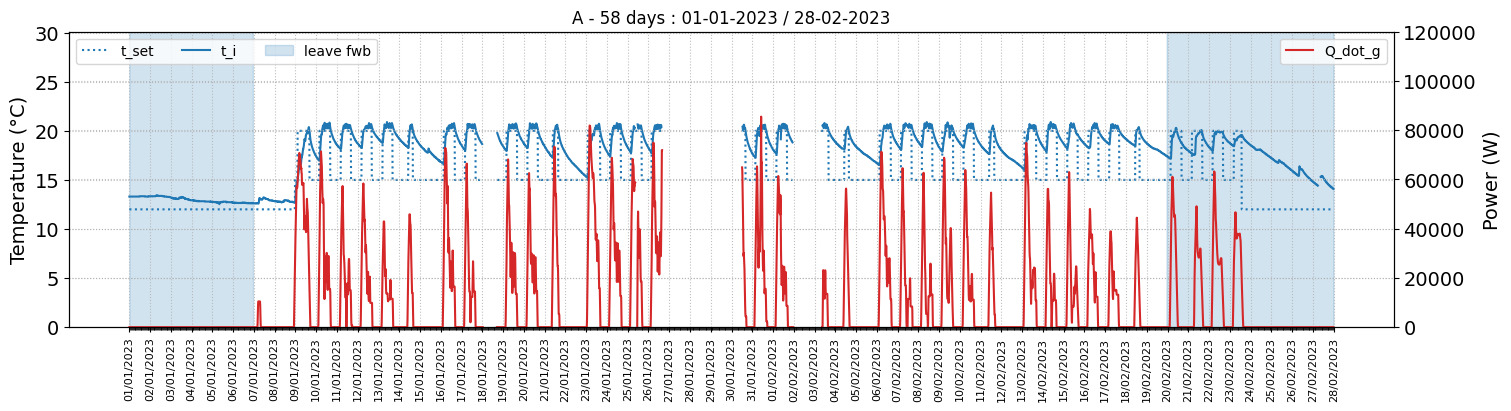

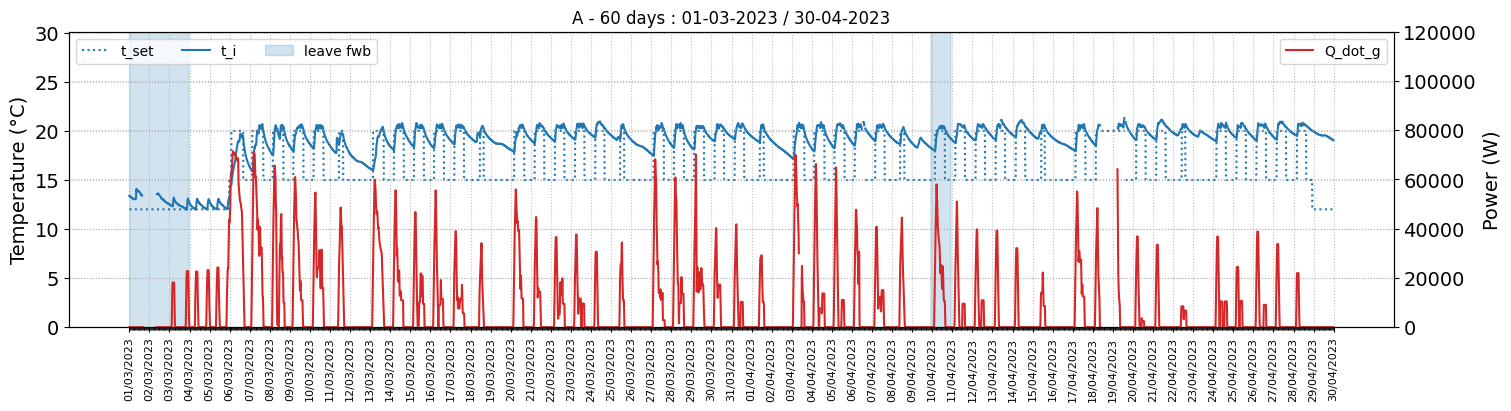

In [13]:
# Number of months per graph
n_months = 2

start = df.index.min().normalize()
end   = df.index.max().normalize() + pd.offsets.MonthEnd(0)

periods = pd.date_range(start=start, end=end, freq=f'{n_months}MS')

for i1 in periods:

    i2 = i1 + pd.offsets.MonthEnd(n_months)
    ndays = (i2 - i1).days

    # Filter df
    df_plot = df.loc[(df.index >= i1) & (df.index < i2)].tz_convert(None)

    if df_plot.empty:
        continue

    day = df_plot.index

    # Limits
    T_min, T_max, T_step = (0, 30.1, 5) if df_plot["t_i"].max() < 25 else (5, 35.1, 5)
    Q_min, Q_max, Q_step = (0, 120002, 20000)

    fig, ax1 = plt.subplots(figsize=(15, 4), constrained_layout=True)

    # Temperature plots
    plot_temperature(ax1, day, df_plot,
                     curves=["t_set", "t_i"],
                     colors=['tab:blue','tab:blue'],
                     linestyles=['dotted','solid'])

    ax1.fill_between(day, T_min * np.ones(len(day)), \
                     T_min + df_plot.leave_fwb * (T_max - T_min), \
                     color='tab:blue', alpha=0.2, label = 'leave fwb' )

    ax1.set_ylim(T_min, T_max)
    ax1.set_yticks(np.arange(T_min, T_max, step=T_step))
    ax1.legend(ncol=8, fontsize=10, loc='upper left')

    # X ticks
    configure_ticks(ax1, i1, i2, freq_major='1D', freq_minor='1H')

    # Power plots
    ax2 = ax1.twinx()
    plot_power(ax2, day, df_plot,
               curves=["Q_dot_g"],
               colors=['tab:red','tab:red'],
               linestyles=['solid','dotted'],
               rolling_span=12)

    ax2.set_ylim(Q_min, Q_max)
    ax2.set_yticks(np.arange(Q_min, Q_max, step=Q_step))
    ax2.legend(ncol=1, fontsize=10, loc='upper right')

    # Title
    plt.title(f"{project} - {int(ndays)} days : {i1:%d-%m-%Y} / {i2:%d-%m-%Y}")
    plt.grid(linestyle='dotted')
    plt.show()

# Failure durations

In [16]:
lstcol = ["Q_dot_g", "Q_dot_g_m1", "Q_dot_g_p1", "t_i"]

out = failure_durations(df, lstcol)
out['failure_hours'].value_counts().sort_index().head(15)

failure_hours
19.25    1
19.50    1
23.00    1
36.50    1
55.75    1
95.50    1
Name: count, dtype: int64

# Interpolate data

In [15]:
# Save uninterpolated column before interpolation
df['t_i_not_interpolated'] = df['t_i'].copy()

# Maximum time interval to allow interpolation
failure_max_h = 6
lstcol = [ 't_i', 't_set', 'f_occ', 
          'Q_dot_g', 'Q_dot_g_m1', 'Q_dot_g_p1', 't_e']

df = interpolate_list(df, lstcol, failure_max_h)

# Periods with no measurement failures

In [17]:
lstcol = ["Q_dot_g", "Q_dot_g_m1", "Q_dot_g_p1", "t_i"]

out = no_failure_durations(df, lstcol)
out = out.sort_values(by = 'no_failure_days', ascending = False).head(30)
df_periods = out.loc[out['no_failure_days'] >= 8].copy()

df_periods = df_periods.head(15).reset_index(drop=True)
df_periods

first                      last  no_failure_days
0 2022-11-07 11:45:00+00:00 2023-01-17 22:45:00+00:00        71.468750
1 2023-03-02 10:00:00+00:00 2023-04-18 07:45:00+00:00        46.916667
2 2023-02-03 10:15:00+00:00 2023-03-01 14:15:00+00:00        26.177083
3 2023-04-19 07:00:00+00:00 2023-04-30 23:45:00+00:00        11.708333

# Select time periods for model identification

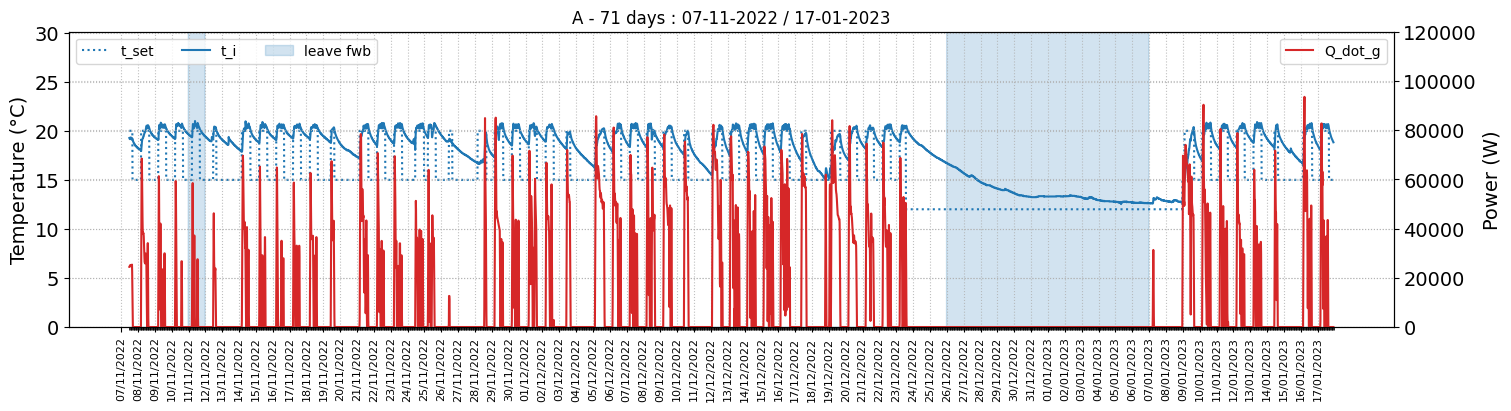

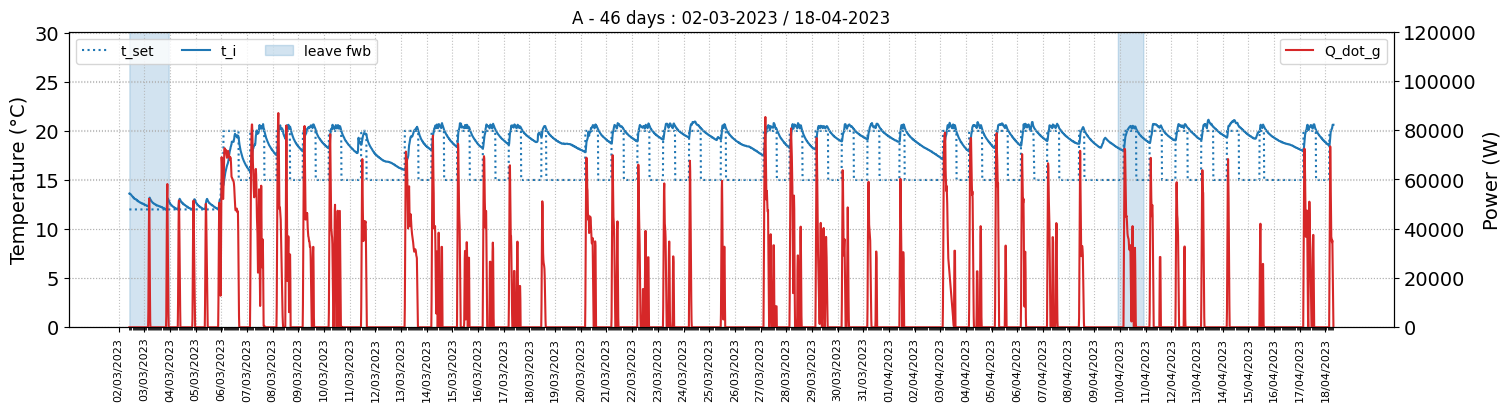

In [18]:
selected_rows = [0, 1]
df_selected = df_periods.loc[selected_rows].reset_index(drop=True)

for idx, row in df_selected.iterrows():
    
    i1 = row["first"]              # start of selected period
    i2 = row["last"]               # end of selected period
    ndays = (i2 - i1).days

    df_plot = df.loc[(df.index >= i1) & (df.index < i2)].tz_convert(None)

    if df_plot.empty:
        continue

    day = df_plot.index

    # Define temperature and power limits
    T_min, T_max, T_step = (0, 30.1, 5) if df_plot["t_i"].max() < 25 else (5, 35.1, 5) 
    Q_min, Q_max, Q_step = (0, 120002, 20000)

    fig, ax1 = plt.subplots(figsize=(15, 4), constrained_layout=True)

    # Temperature plots
    plot_temperature(ax1, day, df_plot, \
                     curves=["t_set", "t_i"], \
                     colors=['tab:blue','tab:blue'], \
                     linestyles = ['dotted', 'solid'])

    ax1.fill_between(day, T_min * np.ones(len(day)), \
                 T_min + df_plot.leave_fwb * (T_max - T_min), \
                 color='tab:blue', alpha=0.2, label = 'leave fwb' )
    
    ax1.set_ylim(T_min, T_max)
    ax1.set_yticks(np.arange(T_min, T_max, step=T_step))
    ax1.legend(ncol=8, fontsize=10, loc='upper left')

    # X-tick configuration
    configure_ticks(ax1, i1, i2, freq_major = '1D', freq_minor = '1H')

    # Power plots (rolling, twin axis)
    ax2 = ax1.twinx()
    plot_power(ax2, day, df_plot, \
               curves=["Q_dot_g"], \
               colors=['tab:red','tab:red'], \
               linestyles = ['solid', 'dotted'], rolling_span = 4)
    
    ax2.set_ylim(Q_min, Q_max)
    ax2.set_yticks(np.arange(Q_min, Q_max, step=Q_step))
    ax2.legend(ncol=1, fontsize=10, loc='upper right')

    # Title and display
    plt.title(
        f"{project} - {int(ndays)} days : {i1.strftime('%d-%m-%Y')} / {i2.strftime('%d-%m-%Y')}"
    )
    plt.grid(linestyle='dotted')
    plt.show()

# Identification

#### Rough estimate of the HTC

In [19]:
# Rough estimation of the Heat Transfer Coefficient
cond = (df['t_e_air'] <= 15)
HTC_estim = df['Q_dot_g'].loc[cond].mean() / (df['t_i'].loc[cond].mean() - df['t_e_air'].loc[cond].mean())

print('Estimated HTC (W/K) : ', int(HTC_estim))

Estimated HTC (W/K) :  869


#### Derivative of the internal temperature

In [20]:
df['dti_t'] = - df['t_i'].diff(periods=-1).fillna(0) / time_step_s

#### Store the data in 1D-arrays

In [21]:
# Copy data from dataframe to 1D-arrays
names = ['Q_dot_g', 'Q_dot_g_m1', 'Q_dot_g_p1',  \
         't_i', 'dti_t', 't_set', 'f_occ', 'leave', 'leave_fwb', \
         't_e',  't_e_air', \
         'I_th', 'I_bh', 'gamma_s_deg', 'h_s_deg', 'theta_z_deg', \
         't_set_default', \
         'ts', 'date_utc', 'hour_utc', \
         'date', 'hour', 'minute', 'dayofmonth', 'month', 'year', 'dayname',
         'dayofweek', 'dayofyear', 'time_float', 'hourofyear_int'] 

arrays = [df[name].values for name in names]

[Q_dot_g, Q_dot_g_m1, Q_dot_g_p1,   \
         t_i, dti_t, t_set, f_occ, leave, leave_fwb, \
         t_e,  t_e_air,  \
         I_th, I_bh, gamma_s_deg, h_s_deg, theta_z_deg, \
         t_set_default,
         ts, date_utc, hour_utc, \
         date, hour, minute, dayofmonth, month, year, dayname,
         dayofweek, dayofyear, time_float, hourofyear_int]  = arrays

#### Solar intensity on the facade

In [22]:
# Compute solar intensity on the main facade
I_dh = np.clip(I_th - I_bh,  0, None)

theta_z_daylight_deg = np.where(theta_z_deg < 85, theta_z_deg, 0)
tan_theta_z = np.tan(theta_z_daylight_deg * np.pi/180)

vectorized_function = np.vectorize(azimuth_norm)
dgamma_z_deg = np.clip(np.abs(vectorized_function(gamma_s_deg - gamma_w_z_deg)), 0, 90)

cos_dg_z = np.cos( dgamma_z_deg * np.pi/180 )
I_b_z    = cos_dg_z * tan_theta_z * I_bh
Iz       = I_dh/2 + rho_ground * I_th/2 + 0.8 * I_b_z

#### Define the periods of effective occupancy

In [23]:
idays = np.arange(0, 7, 1)
time_intervals = np.arange(0, 24, 0.25)

# Effective occupancy profile
h_start_occ_eff = 8
h_stop_occ_eff  = 18

focc_od = np.zeros(len(time_intervals))
indices = np.arange(int(h_start_occ_eff * 4), int(h_stop_occ_eff * 4), 1)
focc_od[indices] = np.ones(len(indices))

focc_dh_eff = np.tile(focc_od, (5,1)) 
focc_dh_eff = np.vstack((focc_dh_eff, np.zeros(len(time_intervals)), np.zeros(len(time_intervals))))

# Compute dow (day of week) and hod (hour of day) arrays
dow = dayofweek.astype(int)
hod = (time_float * 3600 / time_step_s).astype(int) # Vector of 24 * 4 values if time_step = 900 sec

# Compute broadcasted occupancy flags using advanced indexing
f_occ_eff = (1 - leave) * (1 - leave_fwb) * focc_dh_eff[dow, hod]

df['f_occ_eff'] = f_occ_eff

### Locate the beginning of the heating restart periods 

In [24]:
df['start_heat'] = (
    (df['t_set'] > df['t_set'].shift())
    .fillna(False)
    & ((df['Q_dot_g'] > 0) | (df['Q_dot_g_m1'] > 0))
).astype(int)

# Locate time periods 2 hours after the start of the heating system 
start_heat_period = np.maximum.reduce(
    [df["start_heat"].shift(i).fillna(0) for i in range(9)]
)
df['start_heat_period'] = start_heat_period 

restart = df['start_heat_period'].values

### Locate beginning of heating stop periods 

In [25]:
df['stop_heat'] = (
    (df['t_set'] > df['t_set'].shift(-1))
    .fillna(False)
    & ((df['Q_dot_g'] > 0) | (df['Q_dot_g_m1'] > 0))
).astype(int)

# Locate time periods 3 hours after the stop of the heating system 
stop_heat_period = np.maximum.reduce(
    [df["stop_heat"].shift(i).fillna(0) for i in range(13)]
)
df['stop_heat_period'] = stop_heat_period

flag_error = ((df['stop_heat_period'] == 1) & (df['dayofweek'] < 5) & (df['leave'] == 0)).astype(int)

### Filter periods when internal temperature variation is read

In [26]:
read_dti = (
    (f_occ_eff > 0)
    |  (restart == 1)
) 
df['read_dti'] = read_dti.astype(int) # For the graph

### Identify

In [27]:
def fit(x):
    dfr, dfrs, RMS_list, RMS, Tsol = ffit_identification(x, df, df_selected, time_step_s, ts, t_e_air, t_i, dti_t, read_dti, Iz, Q_dot_g, Q_dot_g_m1, flag_error)
    return RMS

In [28]:
# y = \
# [ HTC_estim / 2, HTC_estim, HTC_estim, 200 * 3600, 3600, 10, 0.5  ]

y = \
[ 65.97631017082796, 1037.0216700736132, 21352.496106250976, 603747.9666463464, 2741.9642338631807, 10.370379420128197, 0.3177522812965551  ]

[U0, U1, U2, tau1, tau2, Asol, fQ] = y

xini = np.sqrt([U0, U1, U2, tau1, tau2, Asol, fQ])

# First calculation
# isim = [[x*(0.5+0.5*np.random.rand()) for x in xini] for i in range(len(xini)+1)]

# Refine
isim = [[x*(0.95+0.1*np.random.rand()) for x in xini] for i in range(len(xini)+1)]

ffit_identification.x1   = xini
ffit_identification.xold = xini

def hline(x):
    x_str = ', '.join(map(str, np.square(x)))
    print("==>", ' [', x_str, ' ]')

In [30]:
y = \
[ 65.97631017082796, 1037.0216700736132, 21352.496106250976, 603747.9666463464, 2741.9642338631807, 10.370379420128197, 0.3177522812965551  ]

[U0, U1, U2, tau1, tau2, Asol, fQ] = y

dfr, dfrs, RMS_list, RMS, Ti = ffit_identification(np.sqrt(y), df, df_selected, time_step_s, ts, t_e_air, t_i, dti_t, read_dti, Iz, Q_dot_g, Q_dot_g_m1, flag_error)

0.34 HTCs : 1054  var %:  100 100 100 100 100 100 100


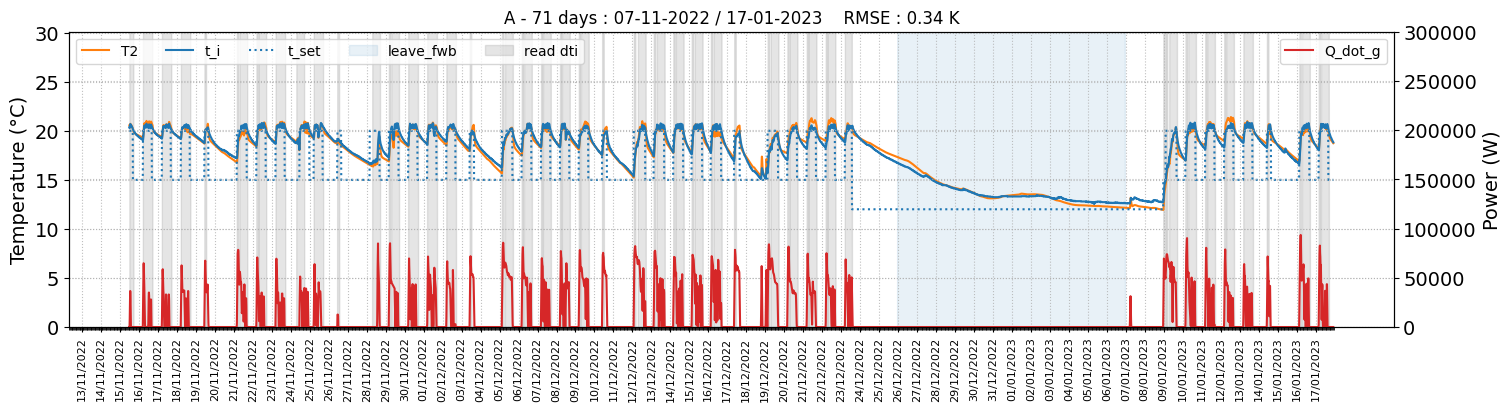

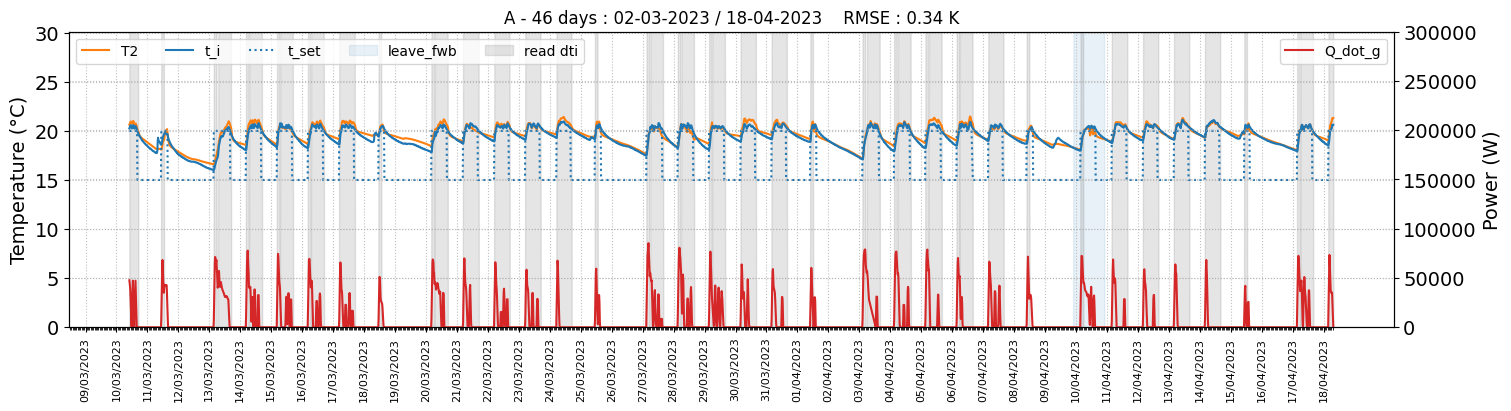

In [31]:
for idx, row in df_selected.iterrows():

    i1 = row["first"]              # start of selected period
    i2 = row["last"]               # end of selected period
    ndays = (i2 - i1).days

    df_plot = dfr.loc[(dfr.index >= i1) & (dfr.index < i2)].tz_convert(None)

    if df_plot.empty:
        continue

    day = df_plot.index

    # Define temperature and power limits
    T_min, T_max, T_step = (0, 30.1, 5) if df_plot["t_i"].max() < 25 else (10, 40.1, 5) 
    Q_min, Q_max, Q_step = (0, 300002, 50000)

    fig, ax1 = plt.subplots(figsize=(15, 4), constrained_layout=True)

    # Temperature plots
    plot_temperature(ax1, day, df_plot, \
                     curves=["T2", "t_i", "t_set"], \
                     colors=['tab:orange','tab:blue','tab:blue'], \
                     linestyles=['solid', 'solid', 'dotted'])
    
    ax1.fill_between(day, T_min * np.ones(len(day)), \
                     T_min + df_plot.leave_fwb * (T_max - T_min), \
                     color='tab:blue', alpha=0.1, label = 'leave_fwb' )
    
    ax1.fill_between(day, T_min * np.ones(len(day)), \
                     T_min + df_plot.read_dti * (T_max - T_min), \
                     color='tab:gray', alpha=0.2, label = 'read dti' )
    
    ax1.set_ylim(T_min, T_max)
    ax1.set_yticks(np.arange(T_min, T_max, step=T_step))
    ax1.legend(ncol=8, fontsize=10, loc='upper left')

    # X-tick configuration
    configure_ticks(ax1, i1, i2, freq_major = '1D', freq_minor = '1H')

    # Power plots (rolling, twin axis)
    ax2 = ax1.twinx()
    plot_power(ax2, day, df_plot, \
               curves=["Q_dot_g"], \
               colors=['tab:red'], \
               linestyles=['solid'], rolling_span = 4)
    
    ax2.set_ylim(Q_min, Q_max)
    ax2.set_yticks(np.arange(Q_min, Q_max, step=Q_step))
    ax2.legend(ncol=1, fontsize=10, loc='upper right')

    # Title and display
    plt.title(
        f"{project} - {int(ndays)} days : {i1.strftime('%d-%m-%Y')} / {i2.strftime('%d-%m-%Y')}"
        f"    RMSE : {round(RMS, 2)} K"
    )
    plt.grid(linestyle='dotted')
    plt.show()

In [32]:
# Check the heat balance
balance = check_balance(dfr)
balance.astype(int)

occupancy  solar  heating  transmission  thermal mass  unbalance  residuals
0          0   1479    23126        -24547            58          0       2165

### Thermal unbalances

In [33]:
# remove leave days periods
dfrqi = pd.concat([dff for dff in dfrs if ((dff['leave'].mean() != 0) & (dff['leave_fwb'].mean() != 0))]).copy()

# BRU timezone 
dfrqi.index = dfrqi.index.tz_convert('Europe/Brussels')

dfrqi.index[0]

Timestamp('2022-11-15 12:45:00+0100', tz='Europe/Brussels')

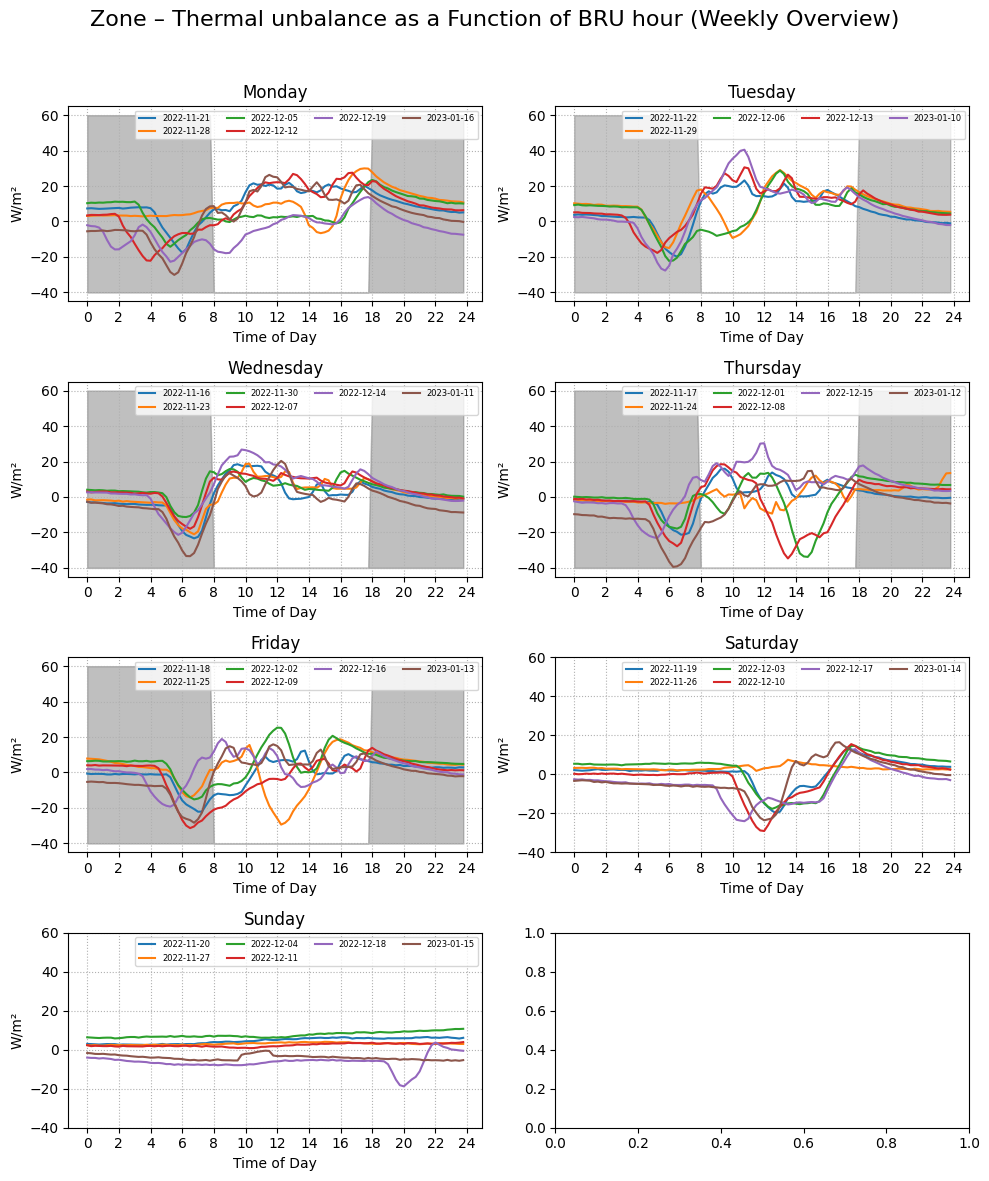

In [34]:
# only include groups of rows where there are exactly 96 rows for each unique date in the index
dfrqi = dfrqi.groupby(dfrqi.index.date).filter(lambda x: len(x) == 96)

suppress_days = []
# suppress_days = [ '2022-12-23']

suppress_dates = [pd.to_datetime(d).date() for d in suppress_days]


col_gr  = "Q_dot_r"       # Gross unbalances
col_eff = "Q_dot_r_eff"   # Effective occupancy internal heat gains

A_floor = A_fl_z

lstcols = ["Q_dot_r", 'f_occ_eff', 'leave', 'leave_fwb', 't_set']
lstdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

qmin_day = -40
qmax_day = 60
qstep    = 20
rspan    = 8

df_list = []

# -------------------------------------------------------------
# Create one global figure with 4 rows × 2 columns
# -------------------------------------------------------------
fig, axes = plt.subplots(4, 2, figsize=(10, 12), sharex=False, sharey=False)
axes = axes.ravel()     # flatten 2D → 1D array for easy indexing

# -------------------------------------------------------------
# LOOP OVER 7 DAYS
# -------------------------------------------------------------
for i in range(7):

    ax = axes[i]   # assign subplot

    mask = (~pd.Series(dfrqi.index.date, index=dfrqi.index).isin(suppress_dates)) \
            & (dfrqi.index.weekday == i) 
    
    weekday_dfr = dfrqi.loc[mask, lstcols].copy()
    
    # Convert time to float (hours)
    weekday_dfr["time"] = weekday_dfr.index.hour + weekday_dfr.index.minute / 60.0
    weekday_dfr["date"] = weekday_dfr.index.date
    
    # ---------------------------------------------------------
    # Plot each date inside the subplot
    # ---------------------------------------------------------
    for date, group in weekday_dfr.groupby("date"):

        # Gross gains (rolling)
        roll_means = group[col_gr].rolling(rspan, center=True, min_periods=1).mean() / A_floor

        # Effective internal heat gains
        group[col_eff] = group['f_occ_eff'] * group[col_gr]

        # Minimum set point value
        t_set_min = group['t_set'].min()

        leave_value = group['leave_fwb'].mean()
        q_r_h       = roll_means.values 
        value_max   = roll_means.max()  
        value_min   = roll_means.min() 

        # Select thermal unbalance profiles
        if (leave_value == 0) & (t_set_min > t_set_leave) & (value_min > qmin_day):
            
            group["day"] = i  
            df_list.append(group[lstcols + [col_eff] + ['day','time',"date"]])
            
            ax.plot(group["time"], q_r_h, label=str(date))

            if (group['f_occ_eff'].max() == 0) & (i < 5) : print(date)

            if i < 5:
                ax.fill_between(
                    group["time"],
                    qmin_day,
                    qmin_day + (qmax_day - qmin_day) * (1 - group['f_occ_eff']),
                    color='tab:gray',
                    alpha=0.1
                )

    # ---------------------------------------------------------
    # Subplot formatting
    # ---------------------------------------------------------
    ax.set_title(lstdays[i])
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("W/m²")
    ax.set_xticks(np.arange(0, 25, 2))
    ax.set_yticks(np.arange(qmin_day, qmax_day + 1, qstep))
    ax.grid(linestyle='dotted')

    ax.legend(fontsize=6, ncol=4)

# -------------------------------------------------------------
# GLOBAL TITLE
# -------------------------------------------------------------
fig.suptitle("Zone – Thermal unbalance as a Function of BRU hour (Weekly Overview)",
             fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Final dataframe
dfqi_dh = pd.concat(df_list, ignore_index=True)

### Day by day average thermal unbalance profile

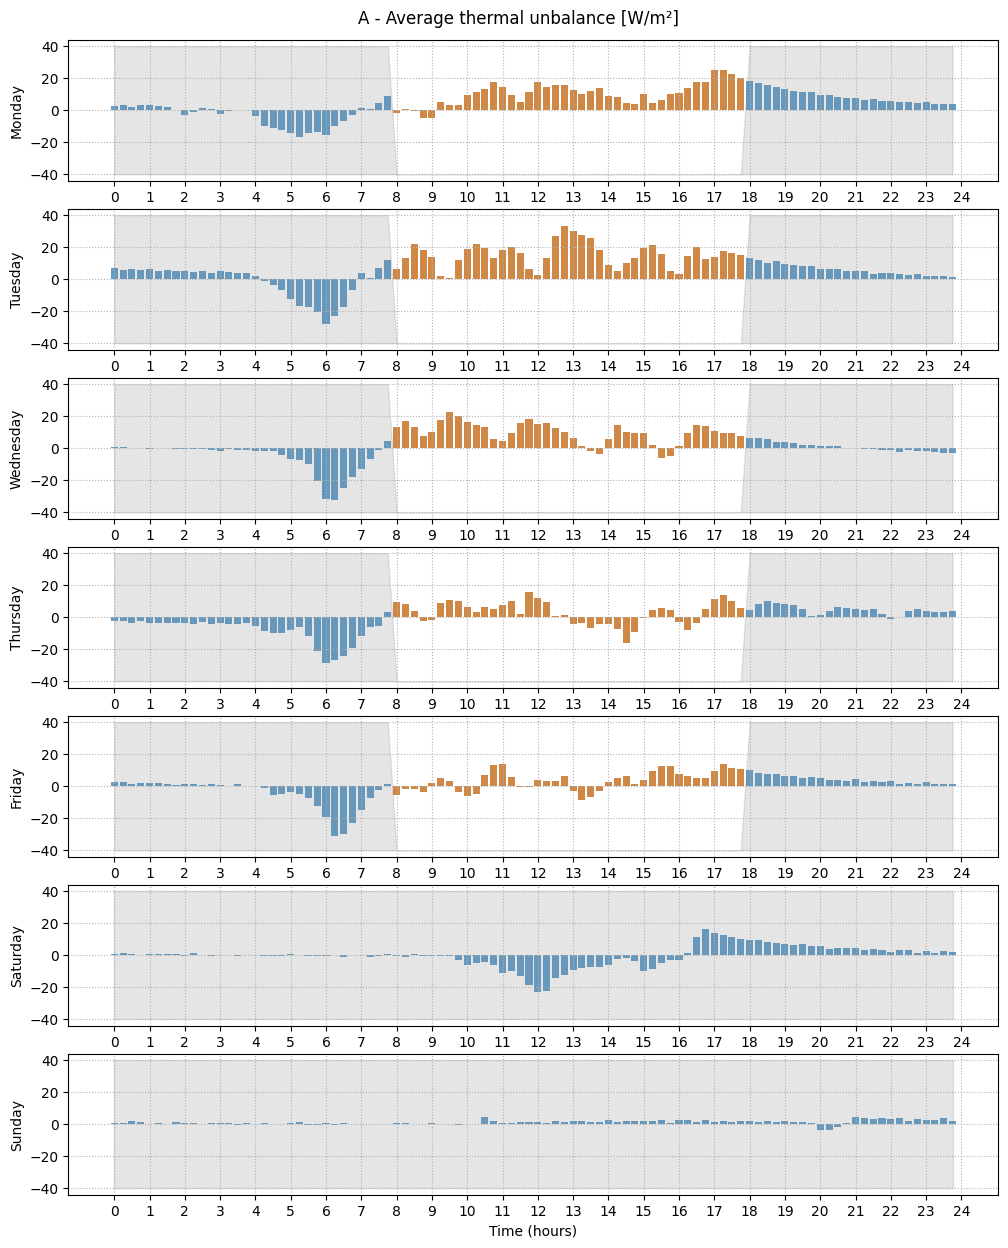

In [35]:
grouped_means = dfqi_dh.groupby(["day", "time"])[["Q_dot_r" , "Q_dot_r_eff", 'f_occ_eff']].mean().reset_index()

Q_r_dh_gr = np.zeros((7, 96))
Q_r_dh    = np.zeros((7, 96))
f_occ_dh  = np.zeros((7, 96))

time_intervals = np.arange(0, 24, 0.25)

for index, row in grouped_means.iterrows():
    day_idx = int(row["day"])
    
     # Get index of time in time_intervals
    time_idx = np.where(np.isclose(time_intervals, row["time"]))[0][0] 
    
    Q_r_dh_gr[day_idx, time_idx] = row["Q_dot_r"]
    Q_r_dh   [day_idx, time_idx] = row["Q_dot_r_eff"]
    f_occ_dh [day_idx, time_idx] = row["f_occ_eff"]

q_r_dh_gr = Q_r_dh_gr / A_floor
q_r_dh    = Q_r_dh / A_floor
    

day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

qmin = -40
qmax = 40
qstep = 20

fig, axes = plt.subplots(7, 1, figsize=(12, 15))

for day in range(7):
    axes[day].bar(time_intervals, q_r_dh_gr[day], width=0.2, alpha=0.7)
    axes[day].bar(time_intervals, q_r_dh[day], width=0.2, alpha=0.7, color = 'C1')

    axes[day].fill_between(time_intervals, \
    qmin * np.ones(len(time_intervals)), qmax - f_occ_dh[day] * (qmax - qmin), color='tab:gray', alpha=0.2)
        
    axes[day].set_ylabel(day_names[day])
    axes[day].set_yticks(np.arange(qmin, qmax + 1, qstep))
    axes[day].set_xticks(np.arange(0, 24 + 1, 1))
    axes[day].grid(True, linestyle = 'dotted')

axes[-1].set_xlabel("Time (hours)")
plt.suptitle(project + " - Average thermal unbalance [W/m²]", y = 0.9)
plt.show()

### Estimate occupancy heat gains

In [36]:
Q_dot_i_occ = (1 - leave) * (1 - leave_fwb) * \
    [Q_r_dh[int(dow), int(ti * 3600/time_step_s)] for dow, ti in zip(dayofweek.tolist(), time_float.tolist())]
df['Q_dot_i_occ']   = Q_dot_i_occ

# Validation

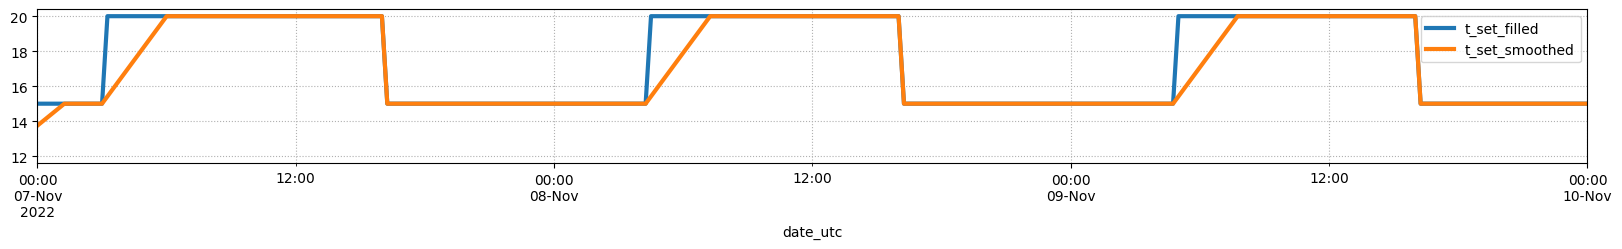

In [37]:
# Complete temperature set points

# Default reheating time of 2 hours before the default set temperatures
shifted = df["t_set_default"].shift(-9).fillna(df["t_set"].iloc[-1])
max_vals = np.maximum(df["t_set_default"], shifted)

df['t_set_filled']  = df["t_set"].fillna(max_vals)
df['dead_band']     = np.where(df["t_set_filled"] >= 19, 0.5, 1.0) 
df['leave_filled']  = df['leave'].fillna(df["leave_fwb"])

t_set_filled  = df['t_set_filled'].values
dead_band     = df['dead_band'].values
leave_filled  = df['leave_filled'].values

# Progressive increase of t_set during the restart
t_set_smoothed = smooth_long_plateaus(t_set_filled, 12)
df['t_set_smoothed'] = t_set_smoothed

lstcol = ['t_set_filled', 't_set_smoothed']
df[lstcol].plot(figsize=(20, 2), linewidth=3)
plt.xlim("2022-11-07", "2022-11-10")  
plt.grid(True, which='both', linestyle='dotted')  

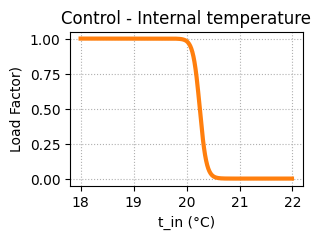

In [38]:
def Xh(Tin, Tset, db):
    # Tin = int(Tin)
    exponent = ( Tin - Tset - db / 2 ) / db / 0.125 
    safe_exponent = np.clip(exponent, -700, 700)  # Avoid overflow
    return 1 / (1 + np.exp(safe_exponent))

x = np.arange(18, 22, 0.01)
y = [Xh(xx, 20, 0.5) for xx in x]

plt.figure(figsize = (3, 2))
plt.plot(x, y, linewidth = 3, color = 'tab:orange')
plt.xlabel('t_in (°C)')
plt.ylabel('Load Factor)')
plt.title('Control - Internal temperature')
plt.grid(linestyle = 'dotted')

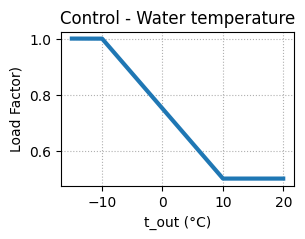

In [39]:
def Xhte(Te, Tset, Xmin):
    X = max(Xmin, min(1, Xmin +  (1 - Xmin) * (Tset - Te) / 20))
    return X

x = np.arange(-15, 20, 0.01)
y = [Xhte(xx, 10, 0.5) for xx in x]

plt.figure(figsize = (3, 2))
plt.plot(x, y, linewidth = 3, color = 'tab:blue')
plt.xlabel('t_out (°C)')
plt.ylabel('Load Factor)')
plt.title('Control - Water temperature')
plt.grid(linestyle = 'dotted')

In [40]:
dfr, RMS = ffit_simulation(U0, U1, U2, tau1, tau2, Asol, df, time_step_s, ts, \
                    month, t_e_air, t_i, dti_t, t_set_smoothed, dead_band, Q_dot_i_occ, Iz, Q_dot_n_z, Xhte, Xh)

In [42]:
dfr['Q_dot_g_filled']    = dfr['Q_dot_g'].fillna(dfr['Q_dot_h'])

dfr['E_kWh_meas_filled'] = dfr['Q_dot_g_filled'] * time_step_s / 3600 / 1000 
dfr['E_kWh_meas_cumsum'] = dfr['E_kWh_meas_filled'].cumsum().where(~dfr['Q_dot_g'].isna())
dfr['E_kWh_meas']        = dfr['Q_dot_g'] * time_step_s / 3600 / 1000 

dfr['E_kWh_calc_full']   = dfr['Q_dot_h'] * time_step_s / 3600 / 1000 
dfr['E_kWh_calc_cumsum'] = dfr['E_kWh_calc_full'].cumsum().where(~dfr['Q_dot_g'].isna())
dfr['E_kWh_calc']        = dfr['E_kWh_calc_full'].where(~dfr['Q_dot_g'].isna())

dfr['E_kWh_calc_full_cumsum'] = dfr['E_kWh_calc_full'].cumsum()

measured_cons_kWh   = dfr.loc[pd.notna(dfr['E_kWh_meas_cumsum']), 'E_kWh_meas_cumsum'].iloc[-1]
calculated_cons_kWh = dfr.loc[pd.notna(dfr['E_kWh_calc_cumsum']), 'E_kWh_calc_cumsum'].iloc[-1]

print('Error on consumption estimation (%) : ' , round(100 * (calculated_cons_kWh - measured_cons_kWh) / measured_cons_kWh, 1))

Error on consumption estimation (%) :  0.1


In [43]:
measured_ti_mean   = dfr.loc[(dfr["Q_dot_g"] > 0), "T2"].mean()
calculated_ti_mean = dfr.loc[(dfr["Q_dot_g"] > 0), "t_i"].mean()

print('measured   ti (°C) : ' , round(measured_ti_mean, 2))
print('calculated ti (°C) : ' , round(calculated_ti_mean, 2))

measured   ti (°C) :  19.47
calculated ti (°C) :  19.6


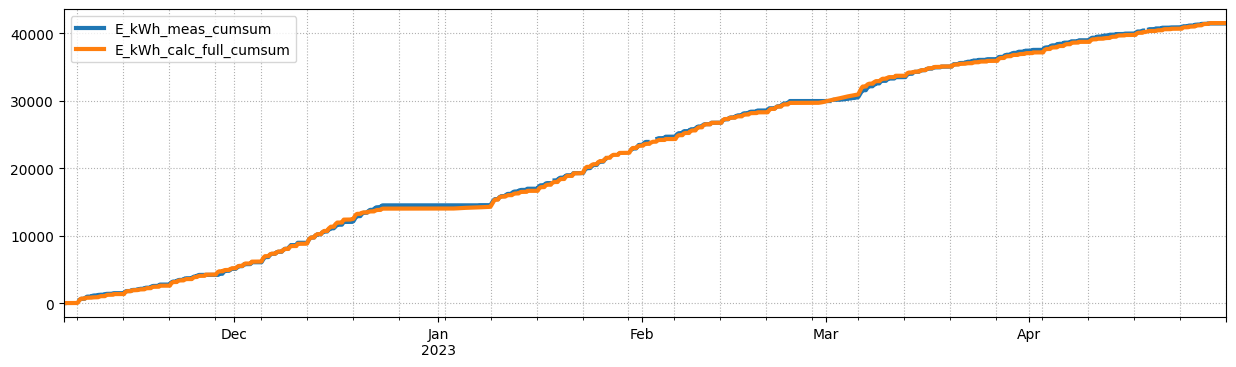

In [44]:
lstcol = ['E_kWh_meas_cumsum', 'E_kWh_calc_full_cumsum']
dfr[lstcol].plot(figsize=(15, 4), linewidth=3)
plt.grid(True, which='both', linestyle='dotted')  

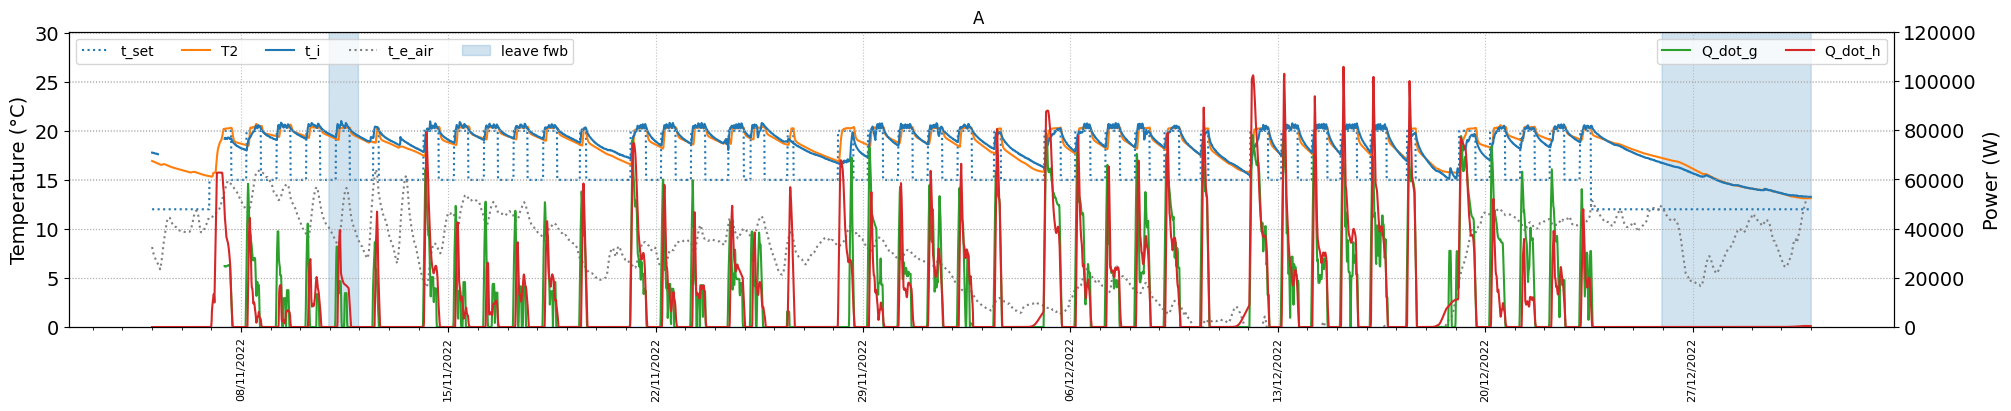

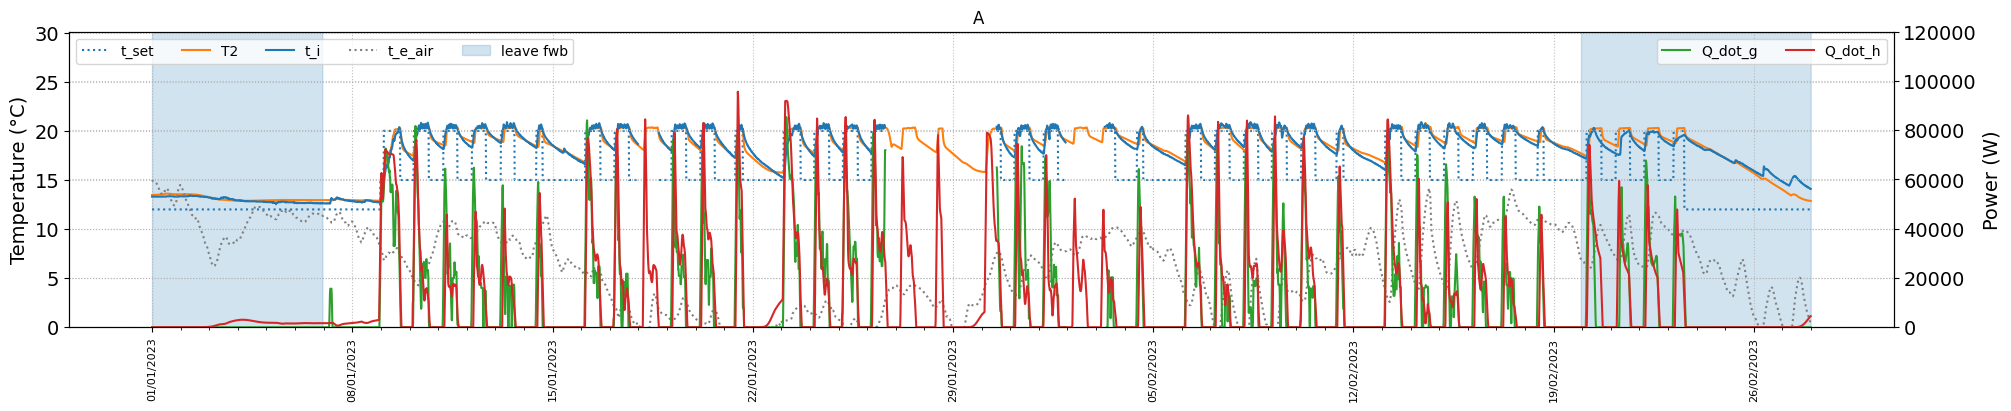

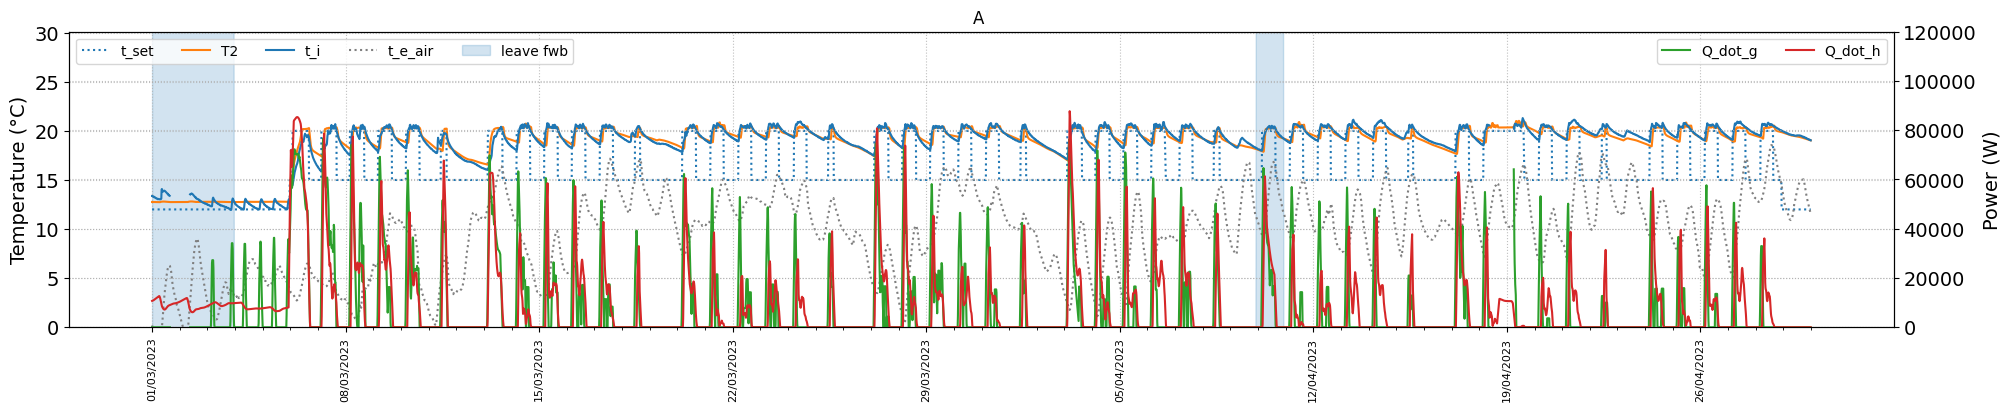

In [46]:
# Number of months per graph
n_months = 2

start = df.index.min().normalize()
end   = df.index.max().normalize() + pd.offsets.MonthEnd(0)

periods = pd.date_range(start=start, end=end, freq=f'{n_months}MS')

for i1 in periods:

    i2 = i1 + pd.offsets.MonthEnd(n_months)
    ndays = (i2 - i1).days

    # Filter df
    df_plot = dfr.loc[(dfr.index >= i1) & (dfr.index < i2)].tz_convert(None)

    if df_plot.empty:
        continue

    day = df_plot.index
    
    # Define temperature and power limits
    T_min, T_max, T_step = (0, 30.1, 5) if df_plot["t_i"].max() < 25 else (5, 35.1, 5) 
    Q_min, Q_max, Q_step = (0, 120002, 20000)
    
    fig, ax1 = plt.subplots(figsize=(20, 4), constrained_layout=True)
    
    # Temperature plots
    plot_temperature(ax1, day, df_plot, \
                     curves=['t_set', 'T2', 't_i', 't_e_air'], \
                     colors=['tab:blue', 'tab:orange', 'tab:blue', 'tab:grey'], \
                     linestyles = ['dotted', 'solid', 'solid', 'dotted'])
    
    ax1.fill_between(day, T_min * np.ones(len(day)), \
                     T_min + df_plot.leave_fwb * (T_max - T_min), \
                     color='tab:blue', alpha=0.2, label = 'leave fwb' )
    
    ax1.set_ylim(T_min, T_max)
    ax1.set_yticks(np.arange(T_min, T_max, step=T_step))
    ax1.legend(ncol=8, fontsize=10, loc='upper left')
    
    # X-tick configuration
    configure_ticks(ax1, i1, i2, freq_major = '7D', freq_minor = '1D')
    
    # Power plots (twin axis)
    ax2 = ax1.twinx()
    plot_power(ax2, day, df_plot, \
               curves=['Q_dot_g', 'Q_dot_h'], \
               colors=['tab:green', 'tab:red'], \
               linestyles = ['solid', 'solid'], rolling_span = 8)
    
    ax2.set_ylim(Q_min, Q_max)
    ax2.set_yticks(np.arange(Q_min, Q_max, step=Q_step))
    ax2.legend(ncol=5, fontsize=10, loc='upper right')
    
    # Title and display
    plt.title(
        f"{project} "
    )
    plt.grid(linestyle='dotted')
    plt.show()

# Plot validation results

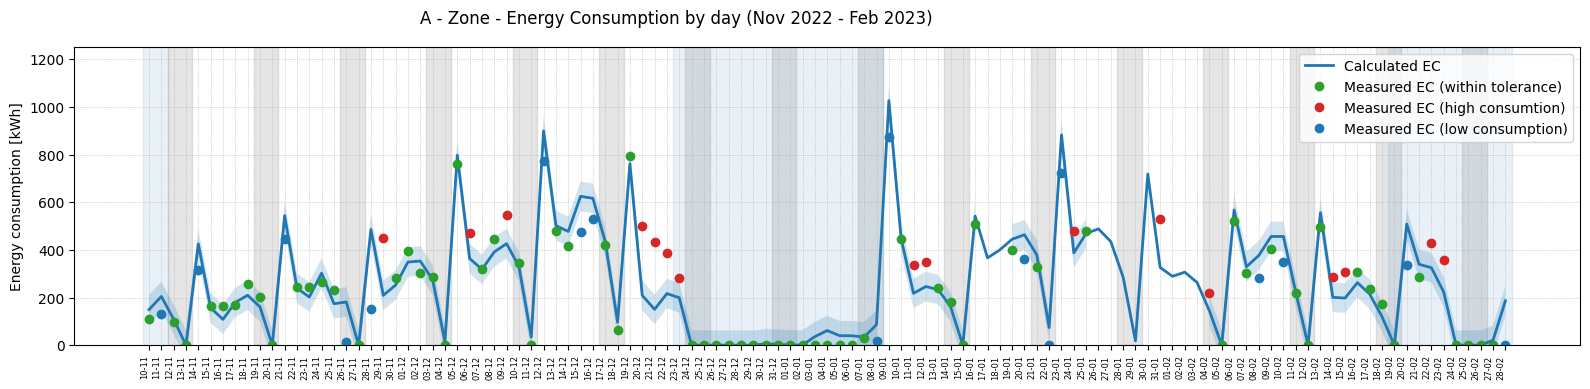

In [47]:
# Custom sum function that ensures all values are non-NaN before summing
def custom_sum(series):
    return series.sum() if series.notna().all() else np.nan

# Custom mean function that ensures all values are non-NaN before averaging
def custom_mean(series):
    return series.mean() if series.notna().all() else np.nan

dfrd = dfr[['E_kWh_meas', 'E_kWh_meas_filled', 'E_kWh_calc_full', 'f_occ', 'leave', 'leave_fwb']].resample('1D').agg({
    'E_kWh_meas'       : custom_sum,
    'E_kWh_meas_filled': custom_sum,
    'E_kWh_calc_full'  : custom_sum,
    'f_occ'            : custom_mean,
    'leave'            : custom_mean,
    'leave_fwb'        : custom_mean
})

# Average consumption during occupied (heated) days
mask = (dfrd['f_occ'] > 0) & pd.notna(dfrd['E_kWh_meas'])
E_kWh_day = dfrd.loc[mask, 'E_kWh_meas'].sum() / len(dfrd.loc[mask])

dfrd['err_cons_kWh'] = dfrd['E_kWh_calc_full'] - dfrd['E_kWh_meas_filled']
dfrd['err_cons_prc'] = (100 * dfrd['err_cons_kWh'] ) / E_kWh_day

dfrd = dfrd[5:] # Remove first 5 days for initialisation

dfrd['day_num'] = np.arange(len(dfrd))

start_date = '2022-11-05 00:00:00'
end_date = '2023-02-28 00:00:00'
dfrd_part1 = dfrd.loc[start_date:end_date]

# Determine the maximum y-axis limit for consistent scaling
y_max = max(dfrd['E_kWh_meas_filled'].max(), dfrd['E_kWh_calc_full'].max()) * 1.1  # Add 10% buffer

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

lst_cols = ['E_kWh_meas', 'E_kWh_meas_filled', 'E_kWh_calc_full']
plot_daily_data(
    dfrd_part1,
    project + ' - Zone - Energy Consumption by day (Nov 2022 - Feb 2023)',
    ax,
    y_max,
    lst_cols,
    E_kWh_day
)

fig.tight_layout()
plt.show()

# Discomfort 

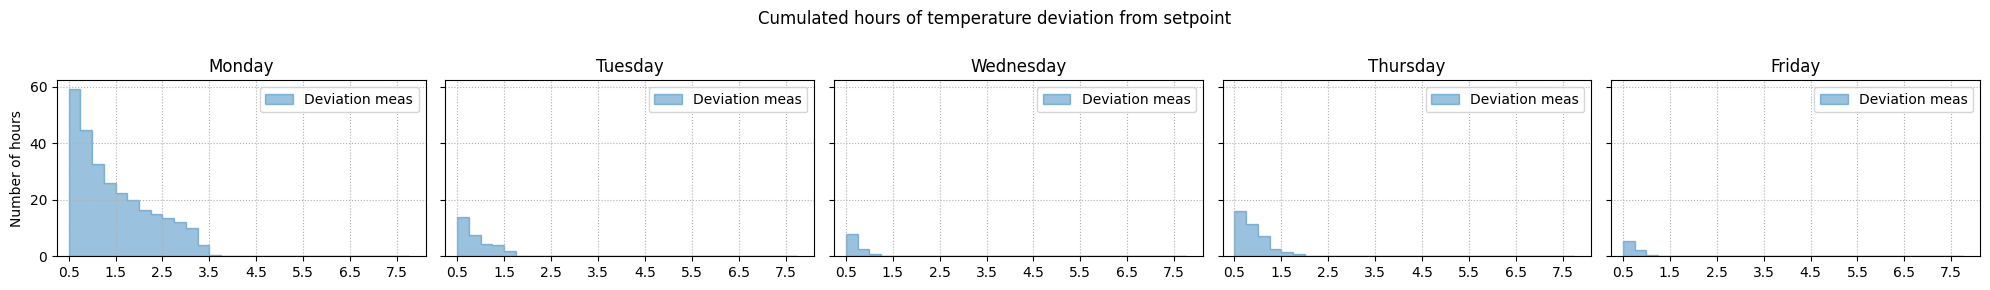

In [48]:
plot_deviation_histograms(
    time_step_s,
    dataframes=[df],
    legends = ['meas'],
    colti = ['t_i'],
    histtype=['stepfilled'],
    colors=['tab:blue'],
    linestyles=['dotted']
)

# Estimate the restart heating control law

In [49]:
# Detect starts and stops of occupancy as well as changes in set points

df['start_occ']  = ((df['f_occ'] > df['f_occ'].shift()).astype(int)).where( (~pd.isna(df['f_occ']))   & (~pd.isna(df['f_occ'].shift())), np.nan )
df['stop_occ']   = ((df['f_occ'] > df['f_occ'].shift(-1)).astype(int)).where( (~pd.isna(df['f_occ'])) & (~pd.isna(df['f_occ'].shift())), np.nan )

df['start_heat'] = ((df['t_set'] > df['t_set'].shift()).astype(int)).where( (~pd.isna(df['t_set']))   & (~pd.isna(df['t_set'].shift())), np.nan )
df['stop_heat']  = ((df['t_set'] > df['t_set'].shift(-1)).astype(int)).where( (~pd.isna(df['t_set'])) & (~pd.isna(df['t_set'].shift())), np.nan )

In [50]:
# Data affecting the control 
t_e_base = 10
df['Dte'] = (t_e_base - df['t_e']).clip(lower = 0)
df['Dti'] = (df['t_set'] - df['t_i']).clip(lower = 0)

In [51]:
# Get all system start times
start_times = df.index[df['start_heat'] == 1]

# Get all occupant arrival times
occ_times = df.index[df['start_occ'] == 1]

# Match each start with the next occurring occupant arrival
occ_times = occ_times[occ_times > start_times[0]]  # Ensure we start matching after the first system start

# Create pairs by iterating through start_times and finding the next matching occ_time
time_differences = []
occ_index = 0

for start_time in start_times:
    # Find the next occupant arrival after the current start
    while occ_index < len(occ_times) and occ_times[occ_index] < start_time  :
        occ_index += 1  # Skip old occupant arrivals
    
    if occ_index < len(occ_times) and (occ_times[occ_index] - start_time).total_seconds() / 3600 < 12 :  
        # Ensure there's a valid occupant arrival
        occ_time = occ_times[occ_index]
        time_diff_hours = (occ_time - start_time).total_seconds() / 3600
        time_differences.append((start_time, occ_time, time_diff_hours))
        occ_index += 1  # Move to the next occupant arrival for future iterations

# Convert result to DataFrame
result_df = pd.DataFrame(time_differences, columns=['System Start', 'Occupant Arrival', 'Time Difference (hours)'])

# Keep only the earliest occupant arrival per day
result_df['Arrival Date'] = result_df['Occupant Arrival'].dt.date  # Extract date
filtered_result_df = result_df.loc[result_df.groupby('Arrival Date')['Occupant Arrival'].idxmin()]

# Drop the helper column
filtered_result_df = filtered_result_df.drop(columns=['Arrival Date'])

# Convert 'Occupant Arrival' to Europe/Brussels timezone
filtered_result_df['Occupant Arrival Brussels'] = (
    filtered_result_df['Occupant Arrival']
    .dt.tz_convert('Europe/Brussels')  
)

dfres = filtered_result_df.copy()

lstr = ['t_i', 't_set', 't_e', 'Dti', 'Dte', 'dayname']

# Add to dfres the df columns listed in lstr, by performing a join based on the 'System Start' column of dfres.
for j, stri in enumerate(lstr):
    dfres[stri] = dfres['System Start'].map(df[stri])

# dfres

 Regression coefficients a, b : 0.5135134953246622 0.058859364779147244
 Standard deviations     a, b : 0.013048712483374183 0.004683041409580149
 R^2 score: 0.9455274021559466


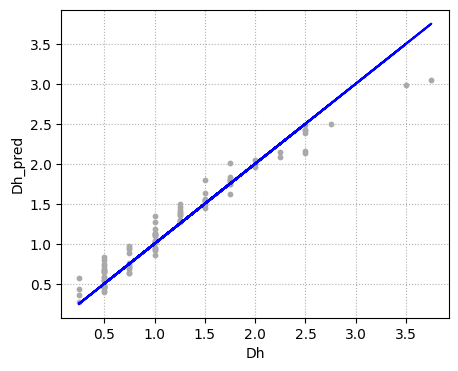

In [52]:
import statsmodels.api as sm

from sklearn.metrics import r2_score

# Multiple linear regression model y = a x1 + b x2 

mask = (dfres['Time Difference (hours)'] > 0)  & (dfres['t_set'] >= 19)

y  = dfres['Time Difference (hours)'].loc[mask]
x1 = dfres['Dti'].loc[mask]
x2 = dfres['Dte'].loc[mask]
x  = [x1, x2]

X = np.column_stack(x)
results = sm.OLS(y, X).fit()
y_pred = results.fittedvalues

a = results.params.iloc[0]
b = results.params.iloc[1]

sigma_a = results.bse.iloc[0]
sigma_b = results.bse.iloc[1]

R2 = r2_score(y, y_pred)

# Regression coefficients
print(" Regression coefficients a, b :", a, b)
print(" Standard deviations     a, b :", sigma_a, sigma_b)
print(" R^2 score:", R2)

yi = a * x1 + b * x2 

plt.figure(figsize=(5,4))
plt.xlabel('Dh')
plt.ylabel('Dh_pred')
plt.grid(linestyle = 'dotted')
plt.scatter(y, yi, c = 'darkgrey', s=10);
plt.plot(y, y,'b-');

In [53]:
[arh, brh] = [ a, b ]

dfres['Dh_pred'] = arh * dfres['Dti'] + brh * dfres['Dte']

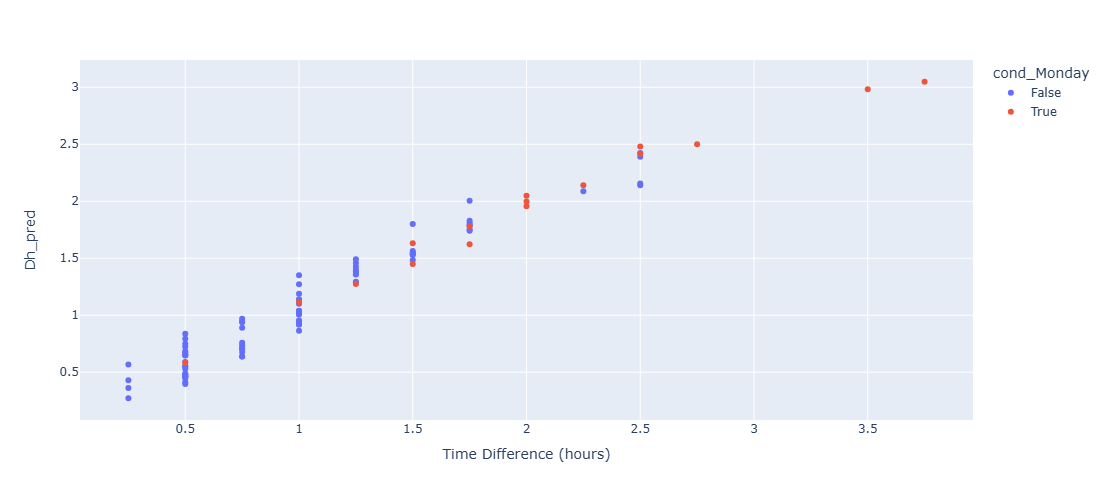

In [54]:
import plotly.express as px

dfres['cond_Monday'] = dfres['dayname'] == 'Monday'

fig = px.scatter(dfres.loc[mask], x= 'Time Difference (hours)', y='Dh_pred', color='cond_Monday', \
                 color_continuous_scale = 'BlueRed',
                     hover_data=['t_e', 'Dti',  'dayname'
                                ], height=500, width=600)
fig.show()

In [55]:
print('Heat up rate : ', round(arh * 60, 1), ' (min/K)')
print('Additional heating time due to external temperature : ', round(brh * 60,1), ' (min/K)')

Heat up rate :  30.8  (min/K)
Additional heating time due to external temperature :  3.5  (min/K)


# Improve the control of the heating restart on mondays

#### Reference

In [56]:
dfr, RMS = ffit_simulation(U0, U1, U2, tau1, tau2, Asol, df, time_step_s, ts, \
                    month, t_e_air, t_i, dti_t, t_set_smoothed, dead_band, Q_dot_i_occ, Iz, Q_dot_n_z, Xhte, Xh)

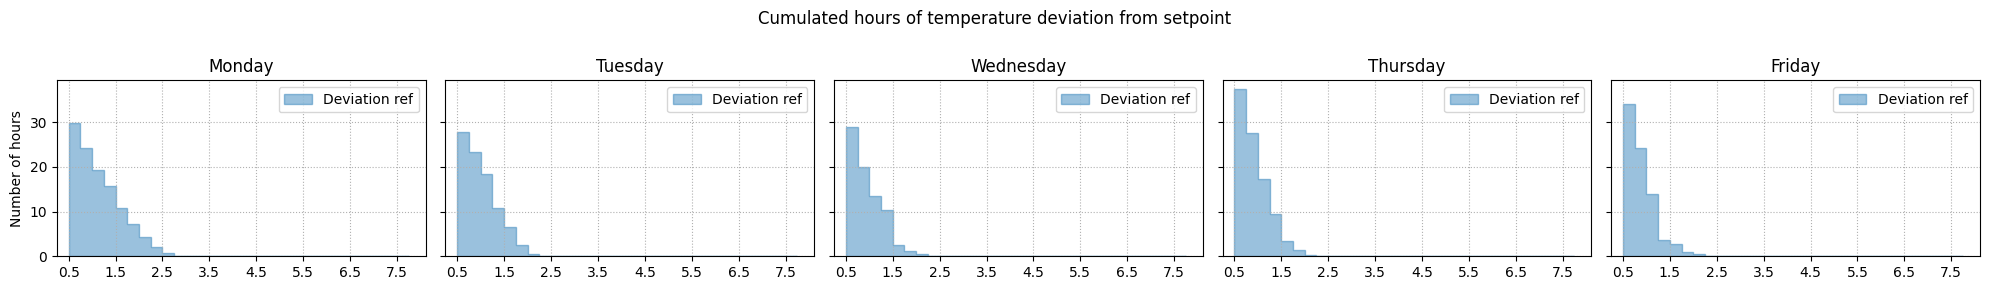

In [57]:
plot_deviation_histograms(
    time_step_s,
    dataframes=[ dfr],
    colti = ['T2'],
    legends = [ 'ref'],
    histtype=['stepfilled'], 
    colors=[ 'tab:blue'], 
    linestyles=[ 'dotted']
)

In [58]:
dfr_ref = dfr.copy()

In [59]:
df = df.copy()

# ----------------------------------------------------
# 1. Build day-based masks
# ----------------------------------------------------

# Normalize index to date
dates = df.index.normalize()

# --- Mondays ---
is_monday = df.index.weekday == 0   # Monday = 0

# --- Days after leave ---
# Per-day leave detection
leave_today = df.groupby(dates)['leave'].transform('max') == 1
# Shift to indicate "previous day was a leave day"
prev_day_leave = leave_today.groupby(dates).shift(1, fill_value=False)

# ----------------------------------------------------
# 2. Compute all shifted versions
# ----------------------------------------------------

shift_2h  = df["t_set_default"].shift(-8)    # Normal days
shift_4h  = df["t_set_default"].shift(-16)   # Mondays
shift_8h  = df["t_set_default"].shift(-32)   # Day after leave

# ----------------------------------------------------
# 3. Choose shift per row based on priority:
#    - Day after leave → 8h
#    - Monday          → 4h
#    - Normal day      → 2h
# ----------------------------------------------------

shifted = np.select(
    [
        prev_day_leave,   # highest priority
        is_monday
    ],
    [
        shift_8h,
        shift_4h
    ],
    default=shift_2h
)

# Convert to Series, fill tail NaN
shifted = pd.Series(shifted, index=df.index).fillna(df["t_set"].iloc[-1])

# ----------------------------------------------------
# 4. Final output column
# ----------------------------------------------------

df["t_set_default_with_shifted"] = np.maximum(df["t_set_default"], shifted)
t_set_default_with_shifted = df["t_set_default_with_shifted"]

In [60]:
# Progressive increase of t_set during the restart
t_set_default_impr= smooth_long_plateaus(t_set_default_with_shifted, 12)

In [61]:
dfr, RMS = ffit_simulation(U0, U1, U2, tau1, tau2, Asol, df, time_step_s, ts, \
                    month, t_e_air, t_i, dti_t, t_set_default_impr, dead_band, Q_dot_i_occ, Iz, Q_dot_n_z, Xhte, Xh)

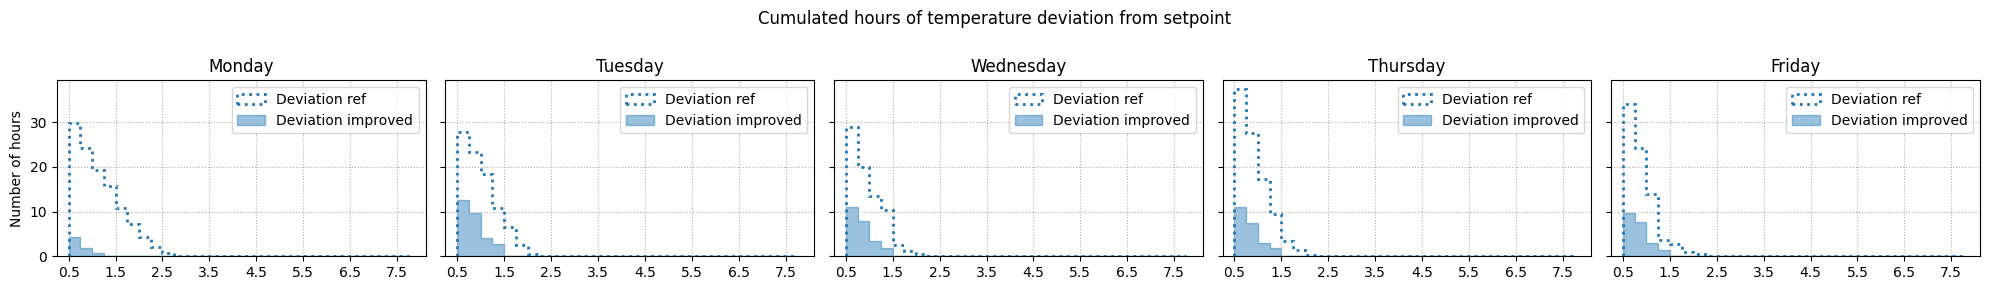

In [62]:
plot_deviation_histograms(
    time_step_s,
    dataframes=[dfr_ref, dfr],
    colti = ['T2', 'T2'],
    legends = ['ref', 'improved'],
    histtype=['step', 'stepfilled'], 
    colors=['tab:blue', 'tab:blue'], 
    linestyles=['dotted', 'dotted']
)

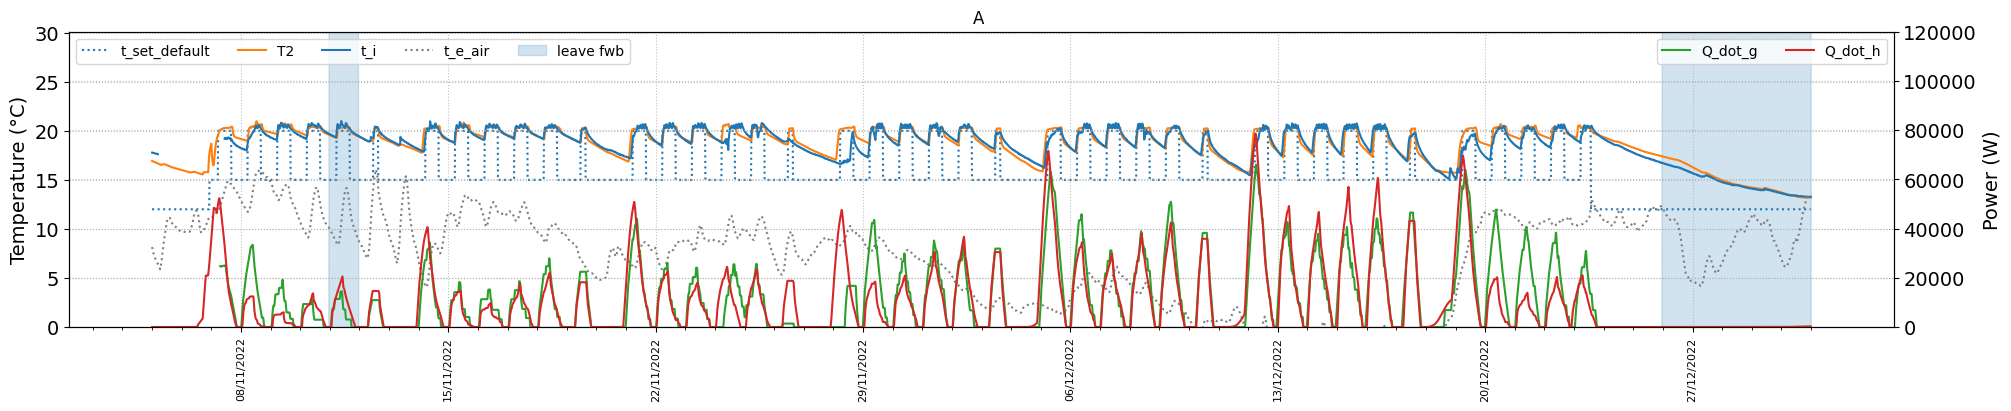

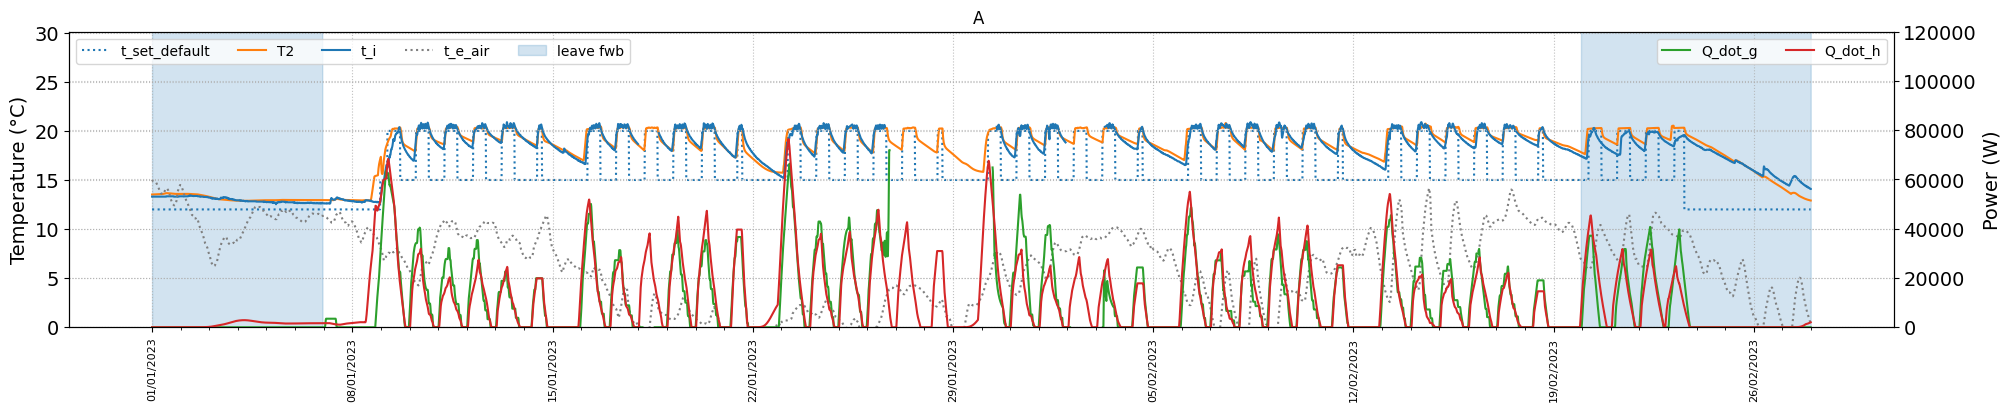

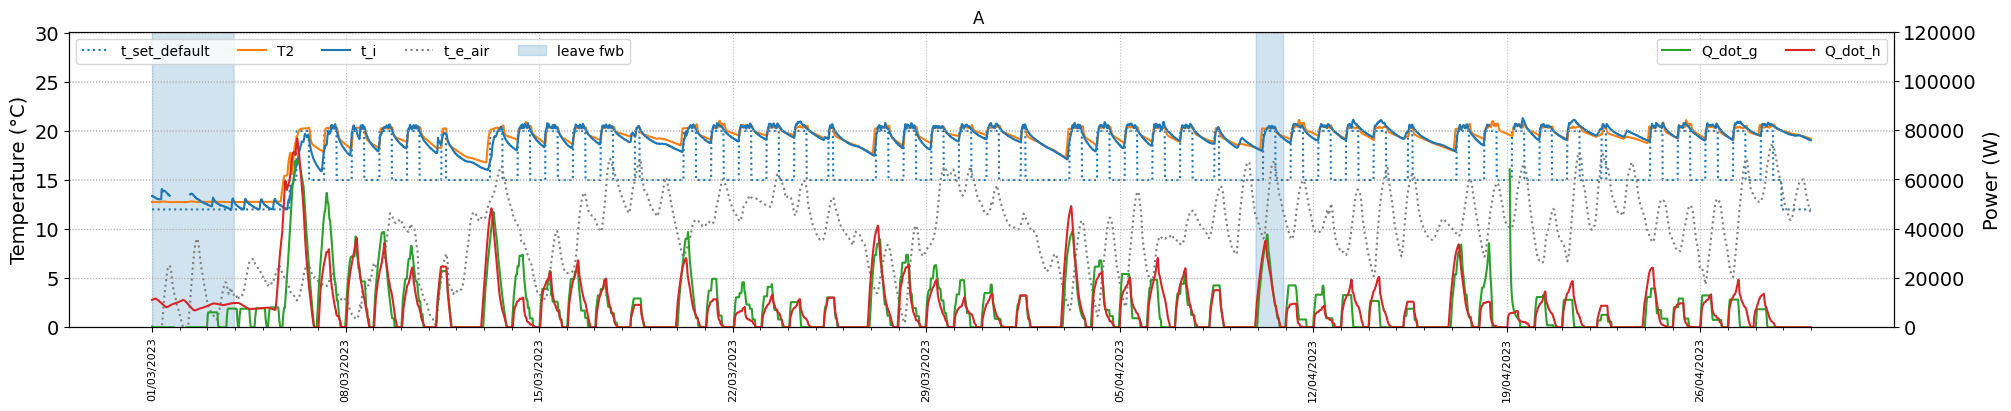

In [63]:
# Number of months per graph
n_months = 2

start = df.index.min().normalize()
end   = df.index.max().normalize() + pd.offsets.MonthEnd(0)

periods = pd.date_range(start=start, end=end, freq=f'{n_months}MS')

for i1 in periods:

    i2 = i1 + pd.offsets.MonthEnd(n_months)
    ndays = (i2 - i1).days

    # Filter df
    df_plot = dfr.loc[(dfr.index >= i1) & (dfr.index < i2)].tz_convert(None)

    if df_plot.empty:
        continue

    day = df_plot.index
    
    # Define temperature and power limits
    T_min, T_max, T_step = (0, 30.1, 5) if df_plot["t_i"].max() < 25 else (5, 35.1, 5) 
    Q_min, Q_max, Q_step = (0, 120002, 20000)
    
    fig, ax1 = plt.subplots(figsize=(20, 4), constrained_layout=True)
    
    # Temperature plots
    plot_temperature(ax1, day, df_plot, \
                     curves=['t_set_default', 'T2', 't_i', 't_e_air'], \
                     colors=['tab:blue', 'tab:orange', 'tab:blue', 'tab:grey'], \
                     linestyles = ['dotted', 'solid', 'solid', 'dotted'])
    
    ax1.fill_between(day, T_min * np.ones(len(day)), \
                     T_min + df_plot.leave_fwb * (T_max - T_min), \
                     color='tab:blue', alpha=0.2, label = 'leave fwb' )
    
    ax1.set_ylim(T_min, T_max)
    ax1.set_yticks(np.arange(T_min, T_max, step=T_step))
    ax1.legend(ncol=8, fontsize=10, loc='upper left')
    
    # X-tick configuration
    configure_ticks(ax1, i1, i2, freq_major = '7D', freq_minor = '1D')
    
    # Power plots (twin axis)
    ax2 = ax1.twinx()
    plot_power(ax2, day, df_plot, \
               curves=['Q_dot_g', 'Q_dot_h'], \
               colors=['tab:green', 'tab:red'], \
               linestyles = ['solid', 'solid'], rolling_span = 36)
    
    ax2.set_ylim(Q_min, Q_max)
    ax2.set_yticks(np.arange(Q_min, Q_max, step=Q_step))
    ax2.legend(ncol=5, fontsize=10, loc='upper right')
    
    # Title and display
    plt.title(
        f"{project} "
    )
    plt.grid(linestyle='dotted')
    plt.show()

In [64]:
dfr     = dfr.rename(columns={"T2": "T2_imp", "Q_dot_h": "Q_dot_h_imp"})

dfcomp = pd.merge(dfr_ref, dfr, left_index=True, right_index=True)

dfcomp['E_kWh_calc_ref']        = dfcomp['Q_dot_h'] * time_step_s / 3600 / 1000 
dfcomp['E_kWh_calc_ref_cumsum'] = dfcomp['E_kWh_calc_ref'].cumsum()
calculated_cons_ref_kWh = dfcomp['E_kWh_calc_ref_cumsum'].iloc[-1]

dfcomp['E_kWh_calc_imp']        = dfcomp['Q_dot_h_imp'] * time_step_s / 3600 / 1000 
dfcomp['E_kWh_calc_imp_cumsum'] = dfcomp['E_kWh_calc_imp'].cumsum()
calculated_cons_imp_kWh = dfcomp['E_kWh_calc_imp_cumsum'].iloc[-1]

print('Consumption difference (%) : ' , round(100 * (calculated_cons_imp_kWh - calculated_cons_imp_kWh) / calculated_cons_imp_kWh, 1))

Consumption difference (%) :  0.0


In [84]:
dfcomp['T2'].mean(), dfcomp['T2_imp'].mean()

(18.402450701471462, 18.55522046511506)